In [1]:
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import integrate
from importlib import reload
import datetime as dt
sys.path.append(r'D:\07. Software\jupyter')
from utils_gfat import lidar_elastic_retrieval, lidarQA, lidar, ecmwf, plot, aeronet, utils
import lidar_processing.lidar_processing.helper_functions as helper_functions
import pdb

In [2]:
#Define date
datestr = '20210709'
date_ = dt.datetime.strptime(datestr, '%Y%m%d')
year, month, day = date_.year, date_.month, date_.day
ymin_referece = 7000
ymax_referece = 8000
ymax = 9000
resolution_range = 7.5 

In [9]:
#Load data
#LIDAR
rs_fl = os.path.join(r'Y:\datos\MULHACEN\1a\%d\%02d\%02d' % (year, month, day), 'mhc_1a_Prs_%s.nc' % datestr)  
dc_fl = os.path.join(r'Y:\datos\MULHACEN\1a\%d\%02d\%02d' % (year, month, day), 'mhc_1a_Pdc_%s_*.nc' % datestr)  
calib_fl = os.path.join(r'D:\07. Software\jupyter\SPIE - AERONET', 'smooth_klett_calib_attbeta_60min_%s_7000-8000.nc' % datestr)
lr_fl = os.path.join(r'D:\07. Software\jupyter\SPIE - AERONET', 'lr_%s.nc' % datestr)  
ecmwf_fl = os.path.join(r'Y:\datos\ECMWF\%s' % year, '%s_granada_ecmwf.nc' % datestr)
outputdir = r'C:\Users\Usuario\Downloads'
beta_fl = os.path.join(r'D:\07. Software\jupyter\SPIE - AERONET', 'smooth_klett_calib_attbeta_10min_%s_7000-8000.nc' % datestr)      

#Attebeta
beta_ds = xr.open_dataset(beta_fl)

#ECMWF
ecmwf_ds = ecmwf.reader(ecmwf_fl)

#Calibration factor
calib_ds = xr.open_dataset(calib_fl)

#LIDAR RATIO
lr_ds = xr.open_dataset(lr_fl)

In [10]:
maindir = r'D:\00. PRODUCCIÓN CIENTÍFICA\00.1 articulos I\ACI_AERONET\lev15_all'
filepath_granada = os.path.join(maindir, '20040101_20211231_Granada.all')
filepath_poyo = os.path.join(maindir, '20110101_20211231_Cerro_Poyos.all')
filepath_albergue = os.path.join(maindir, '20160101_20181231_Albergue_UGR.all')

file = {'granada': filepath_granada, 'poyo': filepath_poyo,
        'albergue': filepath_albergue}
dfd = {}
for _key in file.keys():
    df_ = aeronet.retrieval4CCN_simpson(file[_key])
    dfd[_key] = df_.copy()

In [8]:
# wds = lidar.preprocessing(rs_fl, dc_fl, channels=[6])

ecmwf_ds = ecmwf.reader(ecmwf_fl)



In [14]:
layer_depth = 1000

quasi = {532:  np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
           1064:  np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range'])))}
alpha = {532:  np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
           1064:  np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range'])))}

n = { 532:  {'n50': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n100': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n250': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n290':np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n50_error': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n100_error': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n250_error': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n290_error':np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range'])))},
     1064: {'n50': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n100': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n250': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n290':np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n50_error': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n100_error': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n250_error': np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range']))),
         'n290_error':np.nan*np.ones((len(beta_ds['time']), len(beta_ds['range'])))}}


channel_dict={532: [0,2], 1064:[6]}
rcs_dict={532: 'total_rcs532_an', 1064:'corrected_rcs_06'}

# CONVERSION FACTOR
conversion = {
    'aeronet2017linear': {
        'slope': {
            532: {'n250':{'value': np.nan, 'error':np.nan}},
             1064: {'n250': {'value': 0.189, 'error':0.05}}},
         'intercept': {
             532: {'n250': {'value': np.nan, 'error':np.nan}},
             1064: {'n250': {'value': np.nan, 'error':np.nan}}}},
    'mopsmap': {
        'slope': {
            532: {'n250':{'value': np.nan, 'error':np.nan}},
             1064: {'n250': {'value': 0.208, 'error': 0.05}}},
         'intercept': {
             532: {'n250': {'value': np.nan, 'error':np.nan}},
             1064: {'n250': {'value': np.nan, 'error':np.nan}}}},
    'mopsmapmean': {
        'slope': {
            532: {'n250':{'value': np.nan, 'error':np.nan}},
             1064: {'n250': {'value': 0.238, 'error': 0.05}}},
         'intercept': {
             532: {'n250': {'value': np.nan, 'error':np.nan}},
             1064: {'n250': {'value': np.nan, 'error':np.nan}}}}}

height = beta_ds['range'].values
fulloverlap_height = 600
idx_fulloverlap_height = np.abs(height-fulloverlap_height).argmin()                

for wavelength in [532, 1064]:   
    print('wavelength is %d' % wavelength)
    channels_ = channel_dict[wavelength]
    rcs_name = rcs_dict[wavelength]
    go=True

    #Lidar Ratio
    lr_ = lr_ds['LR%d' % wavelength].mean().values

    try:
        ecmwf_ds = ecmwf.reader(ecmwf_fl)
    except:
        pdb.set_trace()
        go = False
    
    if go:        
        beta_da = beta_ds['quasi%dsm' % wavelength] # wds['attbeta%d_roll' % wavelength]        
        beta_ds['alpha%d' % wavelength] = beta_da*lr_        
        alpha_da = beta_ds['alpha%d' % wavelength]
        beta_ds['aod%d' % wavelength] = alpha_da.fillna(0).integrate(dim='range')
        nearest_fulloverlap_range = alpha_da['range'].sel(range=[600], method="nearest").values[0]
        alpha_at_nearest_fulloverlap_range = alpha_da.sel(range=nearest_fulloverlap_range)
        alpha_da.loc[:,0:nearest_fulloverlap_range] = np.tile(alpha_at_nearest_fulloverlap_range,(alpha_da.loc[:,0:nearest_fulloverlap_range].shape[1],1)).T
                
        #Number concentration
        for n_ in [250]:
            for source_ in ['aeronet2017linear','mopsmap', 'mopsmapmean']:
                slope_ = conversion[source_]['slope'][wavelength]['n%d' % n_]['value']                    
                slope_error_ = conversion[source_]['slope'][wavelength]['n%d' % n_]['error']                    
                nconc_ = slope_*1e6*alpha_da.values
                beta_ds['n%d_%d_%s' % (n_, wavelength, source_)] = (('time', 'range'), nconc_)
                beta_ds['n%d_%d_%s' % (n_, wavelength, source_)].attrs['units'] = '$cm^{-3}$'
                column_nconc_ = 1e12*slope_*beta_ds['aod%d' % wavelength].values
                beta_ds['column_n%d_%d_%s' % (n_, wavelength, source_)] = ('time', column_nconc_)
                beta_ds['column_n%d_%d_%s' % (n_, wavelength, source_)][beta_ds['column_n%d_%d_%s' % (n_, wavelength, source_)]==0] = np.nan
                beta_ds['column_n%d_%d_%s' % (n_, wavelength, source_)].attrs['units'] = '$m^{-2}$'
                nconc_error_ = slope_error_*1e6*alpha_da.values
                column_nconc_error_ = 1e12*slope_error_*beta_ds['aod%d' % wavelength].values
                beta_ds['n%d_%d_error_%s' % (n_, wavelength, source_)] = (('time' , 'range'), nconc_error_)
                beta_ds['n%d_%d_error_%s' % (n_, wavelength, source_)].attrs['units'] = '$cm^{-3}$'
                beta_ds['column_n%d_%d_error_%s' % (n_, wavelength, source_)] = ('time', column_nconc_error_)
                beta_ds['column_n%d_%d_error_%s' % (n_, wavelength, source_)].attrs['units'] = '$m^{-2}$'

wavelength is 532
wavelength is 1064


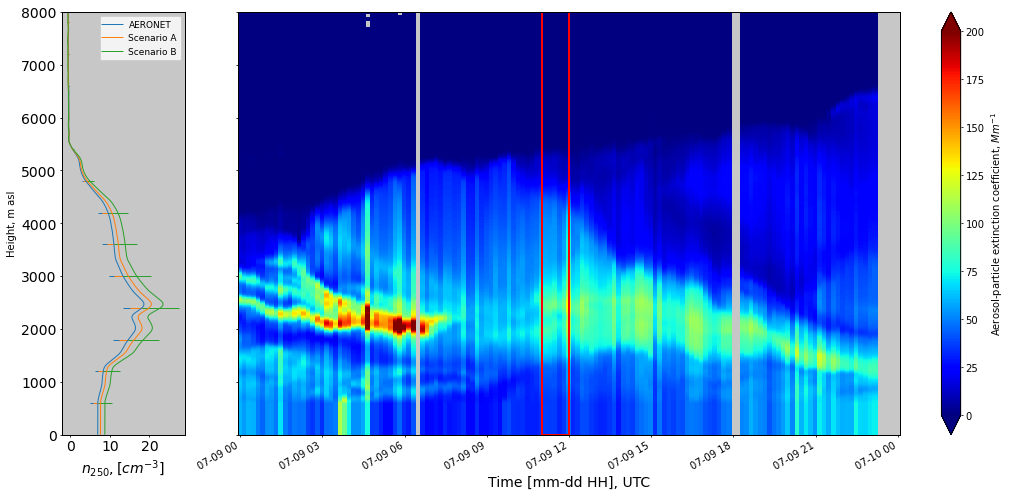

In [17]:
fig, ax = plt.subplots(figsize=[15,7])
ax1 = plt.subplot(1,6,(1))
ax1.errorbar(beta_ds['n250_1064_aeronet2017linear'].sel(time=slice('20210709T110000','20210709T120000')).mean('time').values, 
             beta_ds['range'].values,
            xerr=beta_ds['n250_1064_error_aeronet2017linear'].sel(time=slice('20210709T110000','20210709T120000')).where(beta_ds['range'].values % 200 == 0).mean('time').values, label='AERONET')
ax1.errorbar(beta_ds['n250_1064_mopsmap'].sel(time=slice('20210709T110000','20210709T120000')).mean('time').values, 
             beta_ds['range'].values,
            xerr=beta_ds['n250_1064_error_mopsmap'].sel(time=slice('20210709T110000','20210709T120000')).where(beta_ds['range'].values % 200 == 0).mean('time').values, label='Scenario A')
ax1.errorbar(beta_ds['n250_1064_mopsmapmean'].sel(time=slice('20210709T110000','20210709T120000')).mean('time').values, 
             beta_ds['range'].values,
            xerr=beta_ds['n250_1064_error_mopsmapmean'].sel(time=slice('20210709T110000','20210709T120000')).where(beta_ds['range'].values % 200 == 0).mean('time').values, label='Scenario B')

ax2 = plt.subplot(1,6,(2,6), sharey=ax1)
(beta_ds['alpha1064']*1e6).plot(y='range',vmin=0,vmax=200,cmap='jet', ax=ax2, cbar_kwargs={"label": "Aerosol-particle extinction coefficient, $Mm^{-1}$"})

#Set properties
o_ = plt.setp((ax1.get_yticklabels(), ax1.get_xticklabels()), fontsize=14)
ax1.set_xlabel('$n_{250}, [cm^{-3}]$', fontsize=14)
# ax1.set_xscale('log')
ax1.set_ylim(0,8000)
# ax1.set_xlim(1e-1,5e3)
ax1.legend(fontsize=9)
o_ = plt.setp(ax2.get_yticklabels(), visible=False)
ax1.set_ylabel('Height, m asl')
ax2.set_ylabel('')
ax2.set_xlabel('Time [mm-dd HH], UTC', fontsize=14)

# Create rectangle x coordinates
startTime = dt.datetime.strptime('20210709T110000','%Y%m%dT%H%M%S')
endTime = startTime + dt.timedelta(hours = 1)

# convert to matplotlib date representation
start = mpl.dates.date2num(startTime)
end = mpl.dates.date2num(endTime)
width = end - start

# Plot rectangle
rect = mpl.patches.Rectangle((start, 0), width, 8000, linewidth=2,color='red',fill=False)
ax2.add_patch(rect)
plt.tight_layout()

fig.savefig(os.path.join(outputdir, 'n250_1064_20210709.png'))